In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Download required NLTK data
nltk.download(['vader_lexicon', 'punkt', 'stopwords'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shreyuu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shreyuu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shreyuu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('train.csv')
print("Data shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
df.head()

Data shape: (3636, 2)

Missing values:
 Sentiment        0
News Headline    0
dtype: int64


,Sentiment,News Headline
0,neutral,The value of the orders is over EUR 25mn .
1,neutral,The value of this kind of order amounts usuall...
2,neutral,The technology park will be built near St. Pet...
3,positive,"ADP News - Nov 6 , 2008 - Finnish retail softw..."
4,neutral,Tielinja generated net sales of 7.5 mln euro $...


In [3]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in STOPWORDS]
    stemmer = SnowballStemmer("english")
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

# Apply preprocessing
df['Cleaned Headline'] = df['News Headline'].apply(preprocess_text)

In [4]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores

# Apply sentiment analysis
df['Sentiment_Scores'] = df['Cleaned Headline'].apply(analyze_sentiment)
df['Positive'] = df['Sentiment_Scores'].apply(lambda x: x['pos'])
df['Negative'] = df['Sentiment_Scores'].apply(lambda x: x['neg'])
df['Neutral'] = df['Sentiment_Scores'].apply(lambda x: x['neu'])

print("Sample sentiment analysis results:")
df[['Cleaned Headline', 'Positive', 'Negative', 'Neutral']].head()

Sample sentiment analysis results:


,Cleaned Headline,Positive,Negative,Neutral
0,valu order eur mn,0.000,0.000,1.000
1,valu kind order amount usual euro million,0.362,0.000,0.638
2,technolog park will built near st petersburgba...,0.000,0.000,1.000
3,adp news nov finnish retail softwar develop al...,0.096,0.076,0.828
4,tielinja generat net sale mln euro mln,0.000,0.000,1.000


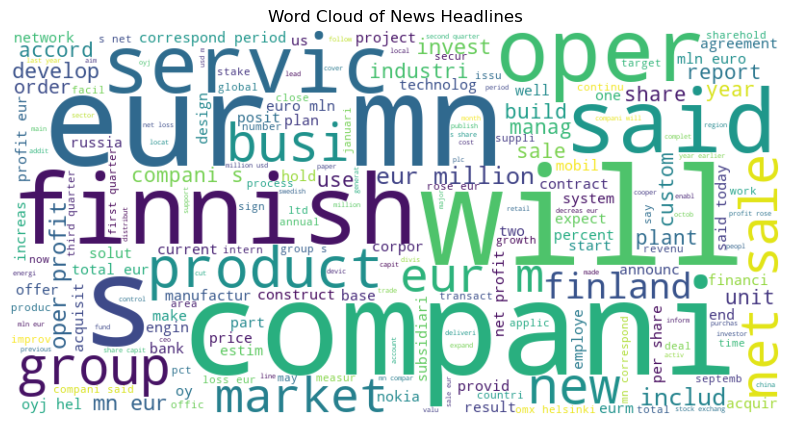

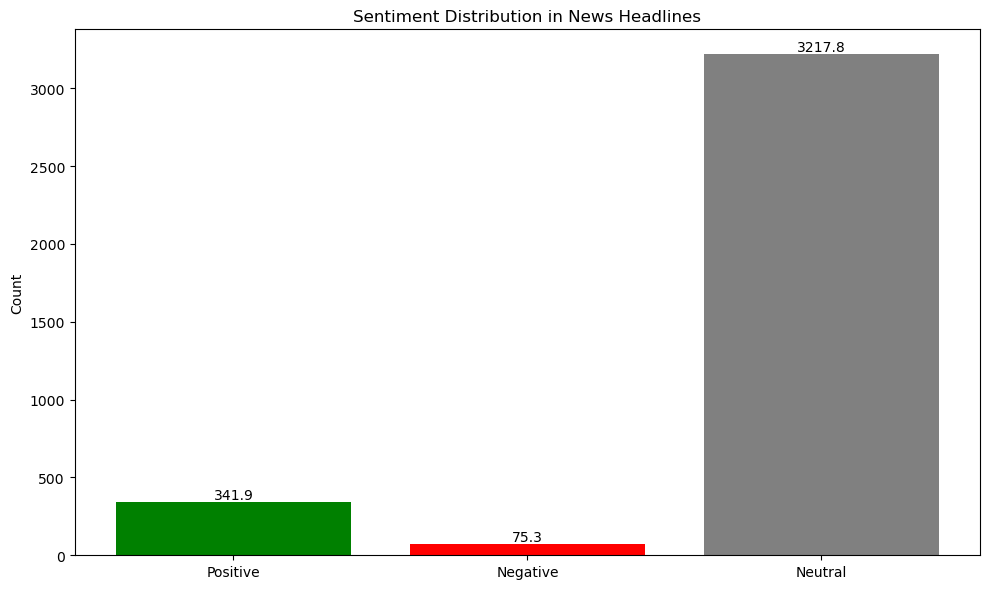

In [5]:
# Word Cloud
text = " ".join(df['Cleaned Headline'])
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     stopwords=STOPWORDS,
                     max_words=200).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Headlines')
plt.show()

# Sentiment Distribution
plt.figure(figsize=(10, 6))
sentiments = ['Positive', 'Negative', 'Neutral']
values = [df['Positive'].sum(), df['Negative'].sum(), df['Neutral'].sum()]

plt.bar(sentiments, values, color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution in News Headlines')
plt.ylabel('Count')
plt.xticks(rotation=0)

for i, v in enumerate(values):
    plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:
# Prepare data for modeling
X = df['Cleaned Headline']
y = df['Sentiment_Scores'].apply(lambda x: 'Positive' if x['pos'] > max(x['neg'], x['neu']) 
                                else 'Negative' if x['neg'] > x['neu'] else 'Neutral')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train model
model = SVC(kernel='linear', random_state=42)
model.fit(X_train_vec, y_train)

# Evaluate
y_pred = model.predict(X_test_vec)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.99      1.00      0.99       720
    Positive       0.00      0.00      0.00         8

    accuracy                           0.99       728
   macro avg       0.49      0.50      0.50       728
weighted avg       0.98      0.99      0.98       728



/Users/shreyuu/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shreyuu/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shreyuu/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [8]:
def analyze_new_text():
    while True:
        text = input("\nEnter text to analyze (or 'quit' to exit): ")
        if text.lower() == 'quit':
            break
            
        cleaned_text = preprocess_text(text)
        scores = analyze_sentiment(cleaned_text)
        
        print("\nAnalysis Results:")
        print(f"Original text: {text}")
        print(f"Cleaned text: {cleaned_text}")
        print(f"Sentiment scores: {scores}")
        print(f"Overall sentiment: ", end='')
        if scores['pos'] > max(scores['neg'], scores['neu']):
            print("Positive 😊")
        elif scores['neg'] > scores['pos'] and scores['neg'] > scores['neu']:
            print("Negative 😠")
        else:
            print("Neutral 🙂")

# Run interactive analysis
analyze_new_text()


Analysis Results:
Original text: is she lonely?
Cleaned text: lone
Sentiment scores: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.2732}
Overall sentiment: Negative 😠

Analysis Results:
Original text: we are at party
Cleaned text: parti
Sentiment scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Overall sentiment: Neutral 🙂

Analysis Results:
Original text: exit
Cleaned text: exit
Sentiment scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Overall sentiment: Neutral 🙂
